In [2]:
import pandas as pd 

In [6]:
df_merged = pd.read_csv("df_merged.csv")
#df_merged.head()
#print(df_merged.dtypes)

## Retrait de toutes les variables dont on a pas besoin pour l'analyse 

In [7]:
# Variables à supprimer
variables_a_supprimer = ['Note press','titre_normalise', 'nom_du_realisateur_bis', 'adult','backdrop_path',
                        'homepage',"original_title","poster_path","status","title","video","nom_du_realisateur_y","tagline", 
                         "Box office", "original_language", "spoken_languages" ,"overview"]
# Supprimer les variables inutiles
df_modified = df_merged.drop(variables_a_supprimer, axis=1)


In [8]:
#regarder le nombre de valeurs manquantes par variable 
masque_valeurs_manquantes = df_modified.isnull()
valeurs_manquantes_par_colonne = masque_valeurs_manquantes.sum()
print("Nombre de valeurs manquantes par variable :")
print(valeurs_manquantes_par_colonne)

Nombre de valeurs manquantes par variable :
Titre original                        0
Notes spectateur                      0
id allocine                           0
date                                260
duree_minutes                        39
Nombre_de_critiques_presse         2076
Nombre_de_notes_spectateurs           0
Nombre_de_critiques_spectateurs       0
mois_sortie_x                       260
annee_sortie_x                      260
nom_du_realisateur_x                  3
belongs_to_collection              2963
budget                                0
genres                                5
id                                    0
imdb_id                               1
popularity                            0
production_companies                 80
production_countries                 28
release_date                          2
revenue                               0
runtime                               0
vote_average                          0
vote_count                          

## Nettoyage des variables 

### Variable genre 

In [9]:
df_modified["genres"].unique()

# Supposons que df_modified soit votre dataframe et 'genres' la colonne contenant les genres
# Divisez les genres en colonnes de dummies
df_dummies = df_modified['genres'].str.get_dummies(', ')

# Groupby sur l'index et sommez les valeurs (évite les duplications)
df_dummies_grouped = df_dummies.groupby(df_dummies.index).sum()

# Ajoutez les colonnes de dummies à votre dataframe d'origine
df_modified = pd.concat([df_modified, df_dummies_grouped], axis=1)

# Supprimez la colonne 'genres' si nécessaire
#df_modified = df_modified.drop('genres', axis=1)

# Affichez le résultat
# Affichez le DataFrame avec les colonnes encodées
df_modified.head()
#df_modified.to_csv("df_modified.csv", index=False)

,Titre original,Notes spectateur,id allocine,date,duree_minutes,Nombre_de_critiques_presse,Nombre_de_notes_spectateurs,Nombre_de_critiques_spectateurs,mois_sortie_x,annee_sortie_x,...,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
0,10 000 days,1.5,239331,NaN,91.0,NaN,32.0,7.0,NaN,NaN,...,0,0,0,0,0,1,0,0,0,0
1,100 Degrees Below Zero,1.2,221267,2015-04-21,89.0,NaN,110.0,51.0,4.0,2015.0,...,0,0,0,0,0,1,0,0,0,0
2,10 Cloverfield Lane,3.6,231144,2016-03-16,103.0,20.0,9399.0,735.0,3.0,2016.0,...,0,1,0,0,0,1,0,1,0,0
3,10 Minutes Gone,1.5,266802,2020-01-10,96.0,NaN,170.0,23.0,1.0,2020.0,...,0,0,0,1,0,0,0,1,0,0
4,10x10,2.0,251534,2018-11-29,87.0,NaN,447.0,54.0,11.0,2018.0,...,0,0,0,0,0,0,0,1,0,0


### Variable durée

#### que pour visualiser et comprendre

In [314]:
# pour visualiser un peu plus clairement
colonnes_a_garder=["Titre original", "id allocine", "id", "imdb_id","duree_minutes", "runtime"]
df_duree = df_modified.loc[:, colonnes_a_garder].copy()
df_duree["difference"]=abs(df_duree["duree_minutes"]-df_duree["runtime"])
df_duree.to_csv("df_duree.csv", index=False)
#df_duree["difference"].value_counts()

In [315]:
#je remplace deja les valeurs manquantes de chaque variable par la valeur de l'autre colonne 

# Remplacer les valeurs manquantes dans duree_minutes par les valeurs de runtime
df_duree['duree_minutes'].fillna(df_duree['runtime'], inplace=True)
# Remplacer les valeurs manquantes dans runtime par les valeurs de duree_minutes
df_duree['runtime'].fillna(df_duree['duree_minutes'], inplace=True)

In [316]:
# on remarque que certains films ont plusieurs observations, on va créer une dataframe 
#qui regroupe seulement ces valeurs dupliques pour visualiser un peu plus 

# Créer une nouvelle DataFrame avec les doublons seulement
df_doublons = df_duree[df_duree.duplicated(subset=["id allocine"],keep=False)]
df_doublons.to_csv("df_doublons.csv", index=False)


In [317]:
# apres avoir visualise on voit qu'on peut garder uniquement l'occurence ou la difference 
#de duree est minimale

nom_colonne_titre = "Titre original"
nom_colonne_duree = "difference"
df_duree = df_duree.sort_values(by=[nom_colonne_titre, nom_colonne_duree], ascending=[True, True])

# Affichez le DataFrame trié
#df_duree.head()

df_duree = df_duree.drop_duplicates(subset="id allocine", keep="first")
len(df_duree)

3530

In [364]:
#on voit que la base des differences est beaucoup plus réduite et plus abordable pour 
#faire le tri
df_duree["difference"].value_counts()

#on remarque que les films ou runtime est egale a 0 la duree duree_minutes est bonne
df_filtre=df_duree.loc[df_duree["runtime"] !=0]
len(df_filtre)
#df_filtre["difference"].value_counts()

3525

In [366]:
#cette etape permet de vérifier par la suite quelle durée garder 
#a partir de l'informaion de imdb 

# Supposons que "difference" est le nom de la colonne
nom_colonne = "difference"
#valeur a regarder = [9,10, 11, 12, 13, 14,15,16,20, 21, 18, 24, 19, 17, 42, 62, 57, 68, 36, 73, 23, 41, 27, 34]
valeur_cible = 9

# Utilisez loc pour sélectionner la ligne où la valeur dans la colonne "difference" est égale à 102
ligne_cible = df_filtre.loc[df_filtre[nom_colonne] == valeur_cible]

# Affichez le résultat
#print("Ligne où la valeur dans la colonne 'difference' est égale à 102 :")
#print(ligne_cible)

#print(ligne_cible[["imdb_id", "duree_minutes", "runtime", "Titre original"]])


In [363]:
#liste des films ou la duree allocine est la bonne récupérée à la main
liste_imdb_id = ["tt2073520", "tt1316037", "tt1711366", "tt1558575", "tt7587282",
                     "tt1535606", "tt1817276", "tt1966359", "tt13265876", "tt2325989",
                     "tt6131450", "tt2007430", "tt3460252", "tt2404299", "tt3062976",
                     "tt3346224", "tt0466893", "tt1805322", "tt4518260", "tt0443465", 
                    "tt1453409","tt3113696", "tt6613952", "tt4257926","tt10238788", 
                     "tt4102722","tt1389139", "tt4940416","tt1855236","tt1754438",
                    "tt1579247","tt7690670","tt3280916","tt1002563"]

In [365]:
# Définir la fonction pour appliquer la logique
def calculer_duree(row):
    if row['runtime'] == 0 or row['imdb_id'] in liste_imdb_id:
        return row['duree_minutes']
    else:
        return row['runtime']

# Appliquer la fonction à la nouvelle colonne
df_duree['duree_du_film'] = df_duree.apply(calculer_duree, axis=1)

# Retirer les colonnes runtime et duree_minutes
df_duree = df_duree.drop(['runtime', 'duree_minutes'], axis=1)
df_duree.to_csv("df_duree.csv", index=False)


#### application à notre base 

In [10]:
#liste des films ou la duree allocine est la bonne récupérée à la main
liste_imdb_id = ["tt2073520", "tt1316037", "tt1711366", "tt1558575", "tt7587282",
                     "tt1535606", "tt1817276", "tt1966359", "tt13265876", "tt2325989",
                     "tt6131450", "tt2007430", "tt3460252", "tt2404299", "tt3062976",
                     "tt3346224", "tt0466893", "tt1805322", "tt4518260", "tt0443465", 
                    "tt1453409","tt3113696", "tt6613952", "tt4257926","tt10238788", 
                     "tt4102722","tt1389139", "tt4940416","tt1855236","tt1754438",
                    "tt1579247","tt7690670","tt3280916","tt1002563"]

# Définir la fonction pour appliquer la logique
def calculer_duree(row):
    if row['runtime'] == 0 or row['imdb_id'] in liste_imdb_id:
        return row['duree_minutes']
    else:
        return row['runtime']

# Appliquer la fonction à la nouvelle colonne
df_modified['duree_du_film'] = df_modified.apply(calculer_duree, axis=1)

# Retirer les colonnes runtime et duree_minutes
df_modified = df_modified.drop(['runtime', 'duree_minutes'], axis=1)

#df_modified.to_csv("df_modified.csv", index=False)

### Variable production companies (pas forcément nécessaire)

In [387]:
df_modified["production_companies"].unique()
liste_des_productions = df_modified['production_companies'].str.split(', ').explode().unique()

print("Liste des producteurs uniques :")
print(liste_des_productions)

Liste des producteurs uniques :
4483


In [11]:
# Supposons que df_modified soit votre dataframe et 'genres' la colonne contenant les genres
# Divisez les genres en colonnes de dummies
df_dummies = df_modified['production_companies'].str.get_dummies(', ')

# Groupby sur l'index et sommez les valeurs (évite les duplications)
df_dummies_grouped = df_dummies.groupby(df_dummies.index).sum()

# Ajoutez les colonnes de dummies à votre dataframe d'origine
df_modified = pd.concat([df_modified, df_dummies_grouped], axis=1)

# Supprimez la colonne 'genres' si nécessaire
#df_modified = df_modified.drop('genres', axis=1)

# Affichez le résultat
# Affichez le DataFrame avec les colonnes encodées
df_modified.head()
#df_modified.to_csv("df_modified.csv", index=False)

KeyboardInterrupt: 

### Variable belongs to collection

In [12]:
# Créer une variable binaire (1 si le film appartient à une collection, 0 sinon)
df_modified['collection'] = df_modified['belongs_to_collection'].notna().astype(int)
df_modified = df_modified.drop('belongs_to_collection', axis=1)
#df_modified.to_csv("df_modified.csv", index=False)

### Variable production_countries

In [430]:
df_modified["production_countries"].unique()
liste_des_pays = df_modified['production_countries'].str.split(', ').explode().unique()

print("Liste des pays uniques :")
print(len(liste_des_pays))

Liste des pays uniques :
76


In [13]:
# Supposons que df_modified soit votre dataframe et 'genres' la colonne contenant les genres
# Divisez les genres en colonnes de dummies
df_dummies = df_modified['production_countries'].str.get_dummies(', ')

# Groupby sur l'index et sommez les valeurs (évite les duplications)
df_dummies_grouped = df_dummies.groupby(df_dummies.index).sum()

# Ajoutez les colonnes de dummies à votre dataframe d'origine
df_modified = pd.concat([df_modified, df_dummies_grouped], axis=1)

# Supprimez la colonne 'genres' si nécessaire
#df_modified = df_modified.drop('genres', axis=1)

# Affichez le résultat
# Affichez le DataFrame avec les colonnes encodées
#df_modified.head()
#df_modified.to_csv("df_modified.csv", index=False)

### Variable date de sortie 

In [14]:
df_modified['date'] = pd.to_datetime(df_modified['date'], errors='coerce')
df_modified['release_date'] = pd.to_datetime(df_modified['release_date'], errors='coerce')

In [434]:
df_modified.dtypes

Titre original                      object
Note press                         float64
Notes spectateur                   float64
id allocine                          int64
date                        datetime64[ns]
                                 ...      
Ukraine                              int64
United Arab Emirates                 int64
United Kingdom                       int64
United States of America             int64
Uruguay                              int64
Length: 120, dtype: object

#### pour vérifier

In [408]:
# pour visualiser un peu plus clairement
colonnes_a_garder=["Titre original", "id allocine", "id", "imdb_id","date","mois_sortie_x","annee_sortie_x", "release_date","mois_sortie_y","annee_sortie_y"]
df_date = df_modified.loc[:, colonnes_a_garder].copy()
#df_date["difference"]=abs(df_duree["duree_minutes"]-df_duree["runtime"])
df_date.to_csv("df_date.csv", index=False)
#df_duree["difference"].value_counts()

#### nettoyage (on garde la date de tmdb)

In [15]:
df_modified['release_date'].fillna(df_modified['date'], inplace=True)
df_modified['mois_sortie_y'].fillna(df_modified['mois_sortie_x'], inplace=True)
df_modified['annee_sortie_y'].fillna(df_modified['annee_sortie_x'], inplace=True)


In [16]:
df_modified = df_modified.drop(['date', 'mois_sortie_x', 'annee_sortie_x','genres'], axis=1)
df_modified = df_modified.rename(columns={'mois_sortie_y': 'mois_sortie', 'annee_sortie_y': 'annee_sortie'})
df_modified.to_csv("df_modified.csv", index=False)

### On obtient donc à ce niveau la table df_modified finale avec laquelle on peut faire de la data visualisation et des stat descriptives

In [438]:
#visualisation colonnes de la df 
#df_modified.columns
len(df_modified.columns)
#df_modified.columns.tolist()

Index(['Titre original', 'Note press', 'Notes spectateur', 'id allocine',
       'Nombre_de_critiques_presse', 'Nombre_de_notes_spectateurs',
       'Nombre_de_critiques_spectateurs', 'nom_du_realisateur_x', 'budget',
       'genres',
       ...
       'Sweden', 'Switzerland', 'Taiwan', 'Thailand', 'Turkey', 'Ukraine',
       'United Arab Emirates', 'United Kingdom', 'United States of America',
       'Uruguay'],
      dtype='object', length=117)

### Analyse graphique

#### Repartition en fonction du genre 

In [20]:
all_genres = df_merged['genres'].str.split(', ').explode().unique()
all_genres

array(['Science Fiction', 'Action', 'Thriller', 'Drama', 'Horror',
       'Crime', 'Mystery', 'Comedy', 'Adventure', 'History', 'War',
       'Fantasy', 'Family', 'Romance', 'TV Movie', 'Western', nan,
       'Music', 'Animation', 'Documentary'], dtype=object)

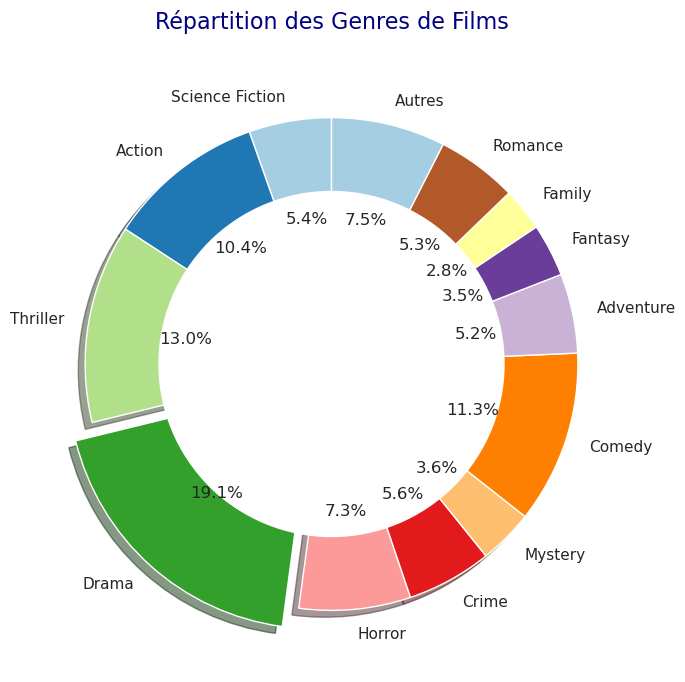

In [54]:
import matplotlib.pyplot as plt
import pandas as pd

# Sélection des colonnes correspondant aux genres binaires
genres_columns = ['Science Fiction', 'Action', 'Thriller', 'Drama', 'Horror',
                   'Crime', 'Mystery', 'Comedy', 'Adventure', 'History', 'War',
                   'Fantasy', 'Family', 'Romance', 'TV Movie', 'Western',
                   'Music', 'Animation', 'Documentary']

# Somme des genres par colonne
genres_counts = df_modified[genres_columns].sum()

# Trouver le genre avec la plus grande part
max_genre = genres_counts.idxmax()

# Regrouper les genres moins fréquents sous "Autres" si nécessaire
threshold = 0.1  # Ajustez cette valeur en fonction de votre préférence
genres_counts['Autres'] = genres_counts[genres_counts < threshold * genres_counts.max()].sum()
genres_counts = genres_counts[genres_counts >= threshold * genres_counts.max()]

# Ajouter une entrée pour le genre principal (avec effet de relief)
explode = [0.1 if genre == max_genre else 0 for genre in genres_counts.index]

# Plot le diagramme en camembert
plt.figure(figsize=(8, 8))
plt.pie(genres_counts, labels=genres_counts.index, autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors, explode=explode,wedgeprops=dict(width=0.4),
        shadow=True)

# Aspect sophistiqué
plt.gca().add_artist(plt.Circle((0, 0), 0.70, fc='white'))

# Titre et personnalisation
plt.title('Répartition des Genres de Films', pad=20, fontsize=16, color='navy')

# Afficher le graphique
plt.show()


Interprétation : 

#### Répartition en fonction du pays de production 

In [48]:
all_countries = df_merged['production_countries'].str.split(', ').explode().unique().tolist()
#all_countries.remove(NaN)
all_countries

['United States of America',
 'United Kingdom',
 'France',
 'Malta',
 'Morocco',
 'Canada',
 'India',
 'Spain',
 'Australia',
 'Iceland',
 'Norway',
 'South Africa',
 'China',
 'Chile',
 'Dominican Republic',
 'Hungary',
 'Japan',
 'Mexico',
 'Italy',
 nan,
 'Bulgaria',
 'Germany',
 'Brazil',
 'Hong Kong',
 'Indonesia',
 'Romania',
 'Switzerland',
 'United Arab Emirates',
 'Argentina',
 'Belgium',
 'Greece',
 'Israel',
 'Sweden',
 'New Zealand',
 'Portugal',
 'Denmark',
 'Singapore',
 'Ghana',
 'Bahamas',
 'Nigeria',
 'Bolivia',
 'Netherlands',
 'Ireland',
 'Peru',
 'Austria',
 'Czech Republic',
 'Costa Rica',
 'Serbia',
 'Malaysia',
 'South Korea',
 'Luxembourg',
 'Taiwan',
 'Poland',
 'Thailand',
 'Puerto Rico',
 'Kenya',
 'Philippines',
 'Cambodia',
 'Colombia',
 'Cuba',
 'Panama',
 'Russia',
 'Finland',
 'Cyprus',
 'Ukraine',
 'Lebanon',
 'Lithuania',
 'Qatar',
 'Jordan',
 'Uruguay',
 'Senegal',
 'Iraq',
 'Albania',
 'Malawi',
 'Turkey',
 'Iran']

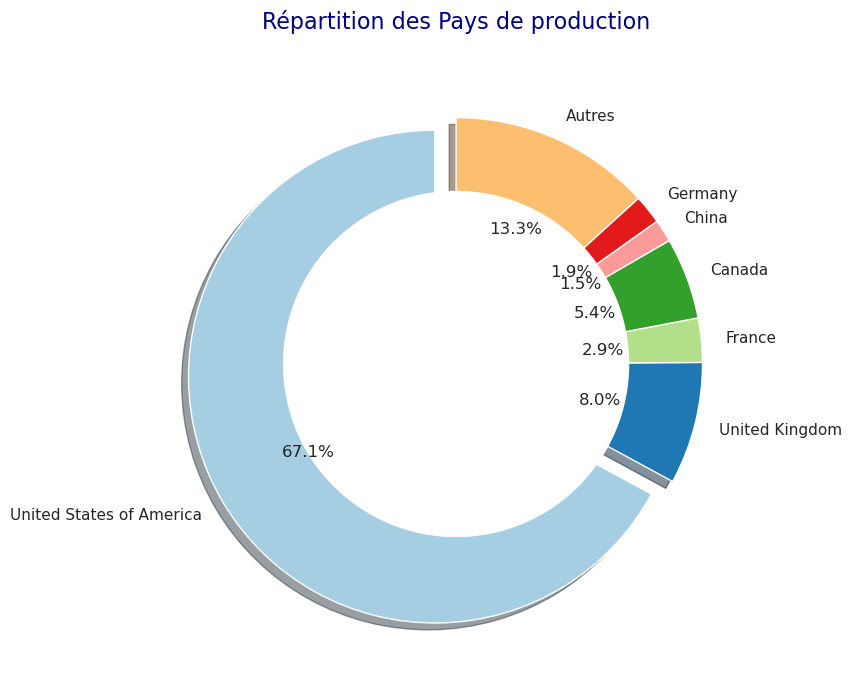

In [55]:
# Sélection des colonnes correspondant aux genres binaires

all_countries= ['United States of America','United Kingdom', 'France', 'Malta', 'Morocco', 'Canada', 'India', 'Spain', 'Australia', 'Iceland', 'Norway',
             'South Africa','China','Chile','Dominican Republic','Hungary','Japan','Mexico','Italy','Bulgaria','Germany','Brazil','Hong Kong','Indonesia',
             'Romania','Switzerland','United Arab Emirates','Argentina','Belgium','Greece','Israel','Sweden','New Zealand', 'Portugal', 'Denmark', 'Singapore',
             'Ghana','Bahamas','Nigeria','Bolivia','Netherlands','Ireland', 'Peru', 'Austria', 'Czech Republic', 'Costa Rica', 'Serbia', 'Malaysia', 'South Korea',
             'Luxembourg','Taiwan','Poland','Thailand','Puerto Rico','Kenya','Philippines','Cambodia', 'Colombia', 'Cuba', 'Panama', 'Russia', 'Finland',
             'Cyprus', 'Ukraine', 'Lebanon', 'Lithuania', 'Qatar', 'Jordan', 'Uruguay', 'Senegal', 'Iraq', 'Albania', 'Malawi', 'Turkey', 'Iran']
# Somme des genres par colonne
countries_counts = df_modified[all_countries].sum()

# Trouver le genre avec la plus grande part
max_countries = countries_counts.idxmax()

# Regrouper les genres moins fréquents sous "Autres" si nécessaire
threshold = 0.015  # Ajustez cette valeur en fonction de votre préférence
countries_counts['Autres'] = countries_counts[countries_counts < threshold * countries_counts.max()].sum()
countries_counts = countries_counts[countries_counts >= threshold * countries_counts.max()]

# Ajouter une entrée pour le genre principal (avec effet de relief)
explode = [0.1 if genre == max_countries else 0 for genre in countries_counts.index]

# Plot le diagramme en camembert
plt.figure(figsize=(8, 8))
plt.pie(countries_counts, labels=countries_counts.index, autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors, explode=explode,wedgeprops=dict(width=0.4),
        shadow=True)

# Aspect sophistiqué
plt.gca().add_artist(plt.Circle((0, 0), 0.70, fc='white'))

# Titre et personnalisation
plt.title('Répartition des Pays de production', pad=20, fontsize=16, color='navy')

# Afficher le graphique
plt.show()